## Clustering text using NLP and K-means clustering

In [277]:
import os
import random
import re
import string

import nltk
import numpy as np
import pandas as pd

from gensim.models import Word2Vec

from nltk import word_tokenize
from nltk.corpus import stopwords

from wordcloud import WordCloud, STOPWORDS

from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [278]:
df_raw = pd.read_csv("dataset/articles_data.csv")

In [279]:
df_raw.head()
df_raw["description"]

0        The National Transportation Safety Board said ...
1        Latest monthly figures reflect continued growt...
2        Autumn-winter collection features designer’s g...
3        Han is the first North Korean player in the Se...
4        The UK government's lawyer, David Johnston arg...
                               ...                        
10432    Get breaking national and world news, broadcas...
10433    The announcement by Julius Baer this week that...
10434    Weston Newswanger is just a normal 5-year-old ...
10435    A detective is haunted by the case of two wome...
10436    Who wanted one-time millionaire Lanny Horwitz ...
Name: description, Length: 10437, dtype: object

## Data preprocessing

In [281]:
def preprocess_text(corpus):
    """Pre-process corpus and generate tokens

    Args:
        corpus: corpus to tokenize.

    Returns:
        Tokenized corpus.
    """
    corpus = str(corpus).lower()  # Lowercase words
    corpus = re.sub(r"\[(.*?)\]", "", corpus)  # Remove [+XYZ chars] in content
    corpus = re.sub(r"\s+", " ", corpus)  # Remove multiple spaces in content
    corpus = re.sub(r"\w+…|…", "", corpus)  # Remove ellipsis (and last word)
    corpus = re.sub(r"(?<=\w)-(?=\w)", " ", corpus)  # Replace dash between words
    corpus = re.sub(
        f"[{re.escape(string.punctuation)}]", "", corpus
    )  # Remove punctuation
    

    tokens = word_tokenize(corpus)  # Get tokens from text
    custom_stopwords = set(stopwords.words("english") + ["news", "new", "top"])
    tokens = [t for t in tokens if not t in custom_stopwords]  # Remove stopwords
    tokens = ["" if t.isdigit() else t for t in tokens]  # Remove digits
    tokens = [t for t in tokens if len(t) > 1]  # Remove short tokens
    preprocessed_texts = ' '.join(tokens)
    return tokens

In [282]:
text_columns = ["title", "description", "content"]

df = df_raw.copy()
df["content"] = df["content"].fillna("")

# df["content"]
df["description"]

0        The National Transportation Safety Board said ...
1        Latest monthly figures reflect continued growt...
2        Autumn-winter collection features designer’s g...
3        Han is the first North Korean player in the Se...
4        The UK government's lawyer, David Johnston arg...
                               ...                        
10432    Get breaking national and world news, broadcas...
10433    The announcement by Julius Baer this week that...
10434    Weston Newswanger is just a normal 5-year-old ...
10435    A detective is haunted by the case of two wome...
10436    Who wanted one-time millionaire Lanny Horwitz ...
Name: description, Length: 10437, dtype: object

In [283]:
for col in text_columns:
    df[col] = df[col].astype(str)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10437 entries, 0 to 10436
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       10437 non-null  int64  
 1   source_id                        10437 non-null  object 
 2   source_name                      10437 non-null  object 
 3   author                           9417 non-null   object 
 4   title                            10437 non-null  object 
 5   description                      10437 non-null  object 
 6   url                              10436 non-null  object 
 7   url_to_image                     9781 non-null   object 
 8   published_at                     10436 non-null  object 
 9   content                          10437 non-null  object 
 10  top_article                      10435 non-null  float64
 11  engagement_reaction_count        10319 non-null  float64
 12  engagement_comment

In [284]:
# Create article column based on title, description, and content
df["article"] = df[text_columns].apply(lambda x: " | ".join(x), axis=1)
df["article"]

0        NTSB says Autopilot engaged in 2018 California...
1        Unemployment falls to post-crash low of 5.2% |...
2        Louise Kennedy AW2019: Long coats, sparkling t...
3        North Korean footballer Han joins Italian gian...
4        UK government lawyer says proroguing parliamen...
                               ...                        
10432    Drop in US service sector activity raises econ...
10433    Banker defections pose challenge for Credit Su...
10434    A 5-year-old cancer survivor donates 3,000 toy...
10435    Fateful Connection | A detective is haunted by...
10436    Love, Hate & Obsession | Who wanted one-time m...
Name: article, Length: 10437, dtype: object

In [285]:
df["tokens"] = df["article"].map(lambda x: preprocess_text(x))
df["tokens"]

0        [ntsb, says, autopilot, engaged, california, t...
1        [unemployment, falls, post, crash, low, latest...
2        [louise, kennedy, aw2019, long, coats, sparkli...
3        [north, korean, footballer, han, joins, italia...
4        [uk, government, lawyer, says, proroguing, par...
                               ...                        
10432    [drop, us, service, sector, activity, raises, ...
10433    [banker, defections, pose, challenge, credit, ...
10434    [year, old, cancer, survivor, donates, toys, c...
10435    [fateful, connection, detective, haunted, case...
10436    [love, hate, obsession, wanted, one, time, mil...
Name: tokens, Length: 10437, dtype: object

In [287]:
# Remove duplicated after preprocessing
_, idx = np.unique(df["tokens"], return_index=True)
df = df.iloc[idx, :]

# Remove empty values
df = df.loc[df.tokens.map(lambda x: len(x) > 0), ["article", "tokens"]]

print(f"Original data: {df_raw.shape}")
print(f"Pre-processed data: {df.shape}")

Original data: (10437, 15)
Pre-processed data: (9882, 2)


### looking at vocabulary

In [288]:
from collections import Counter 

In [289]:
docs = df["article"].values
tokenized_docs = df["tokens"].values

vocab = Counter()
for token in tokenized_docs:
    vocab.update(token)

In [290]:
vocab.most_common(10)

[('us', 2757),
 ('said', 2519),
 ('year', 1781),
 ('president', 1756),
 ('trump', 1705),
 ('world', 1620),
 ('says', 1511),
 ('one', 1418),
 ('two', 1284),
 ('first', 1195)]

### Vectorization using word embeddings

In [291]:
def vectorize(list_of_docs, model):
    """Generate vectors for list of documents using a Word Embedding

    Args:
        list_of_docs: List of documents
        model: Gensim's Word Embedding

    Returns:
        List of document vectors
    """
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features

In [292]:
model = Word2Vec(sentences=tokenized_docs, vector_size=100, workers=1, seed=42)

In [293]:
model.wv.most_similar("trump")

[('trumps', 0.988541841506958),
 ('president', 0.9746480584144592),
 ('donald', 0.9274919629096985),
 ('ivanka', 0.9203823804855347),
 ('impeachment', 0.9195769429206848),
 ('pences', 0.9152196645736694),
 ('avlon', 0.9148270487785339),
 ('biden', 0.9146018624305725),
 ('breitbart', 0.914395272731781),
 ('vice', 0.9067230820655823)]

In [306]:
vectorized_docs = vectorize(tokenized_docs, model=model)
len(vectorized_docs), len(vectorized_docs[0])
# vectorized_docs

(9882, 100)

In [295]:
def mbkmeans_clusters(X, k, mb=500, print_silhouette_values=False):
    """Generate clusters.

    Args:
        X: Matrix of features.
        k: Number of clusters.
        mb: Size of mini-batches. Defaults to 500.
        print_silhouette_values: Print silhouette values per cluster.

    Returns:
        Trained clustering model and labels based on X.
    """
    km = MiniBatchKMeans(n_clusters=k, batch_size=mb).fit(X)
    print(f"For n_clusters = {k}")
    print(f"Silhouette coefficient: {silhouette_score(X, km.labels_):0.2f}")
    print(f"Inertia:{km.inertia_}")

    if print_silhouette_values:
        sample_silhouette_values = silhouette_samples(X, km.labels_)
        print(f"Silhouette values:")
        silhouette_values = []
        for i in range(k):
            cluster_silhouette_values = sample_silhouette_values[km.labels_ == i]
            silhouette_values.append(
                (
                    i,
                    cluster_silhouette_values.shape[0],
                    cluster_silhouette_values.mean(),
                    cluster_silhouette_values.min(),
                    cluster_silhouette_values.max(),
                )
            )
        silhouette_values = sorted(
            silhouette_values, key=lambda tup: tup[2], reverse=True
        )
        for s in silhouette_values:
            print(
                f"    Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.2f} | Min:{s[3]:.2f} | Max: {s[4]:.2f}"
            )
    return km, km.labels_



For n_clusters = 5 The average silhouette_score is : 0.23626238
For n_clusters = 6 The average silhouette_score is : 0.27466267
For n_clusters = 7 The average silhouette_score is : 0.25501722
For n_clusters = 8 The average silhouette_score is : 0.19206016
For n_clusters = 9 The average silhouette_score is : 0.17802669
For n_clusters = 2 The average silhouette_score is : 0.25150803


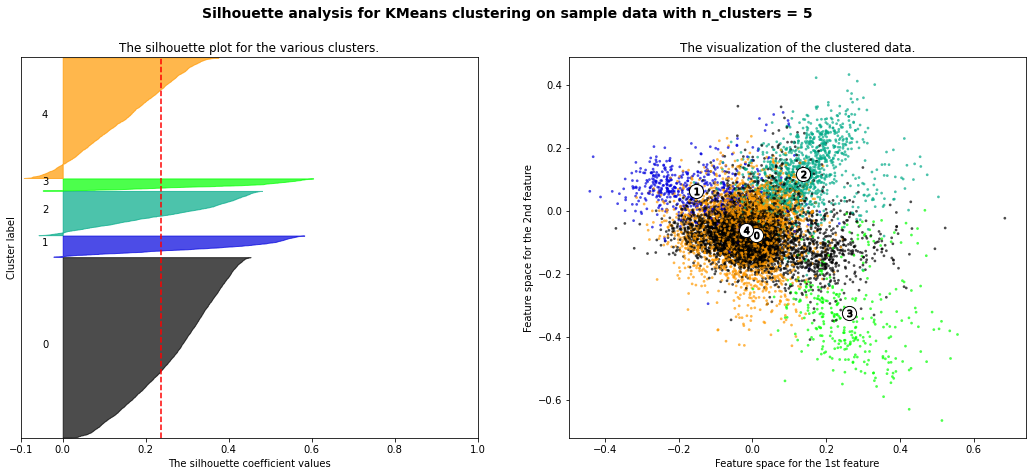

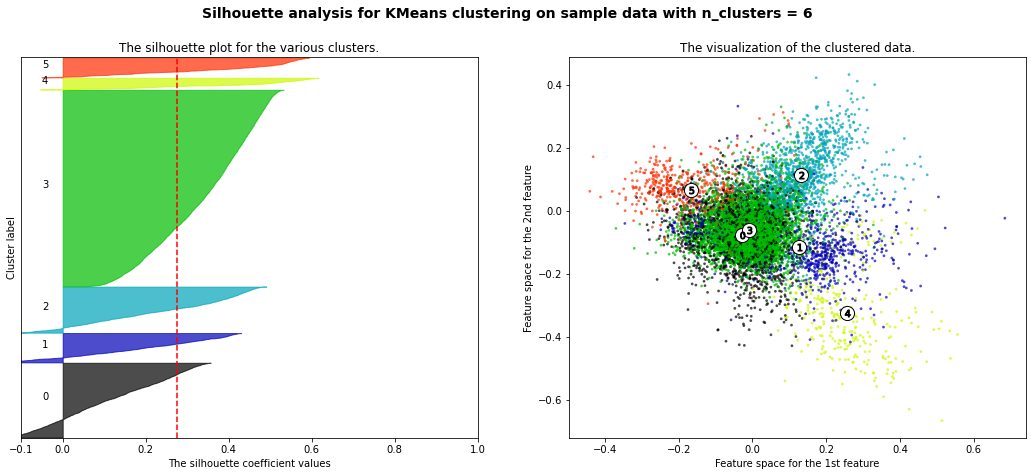

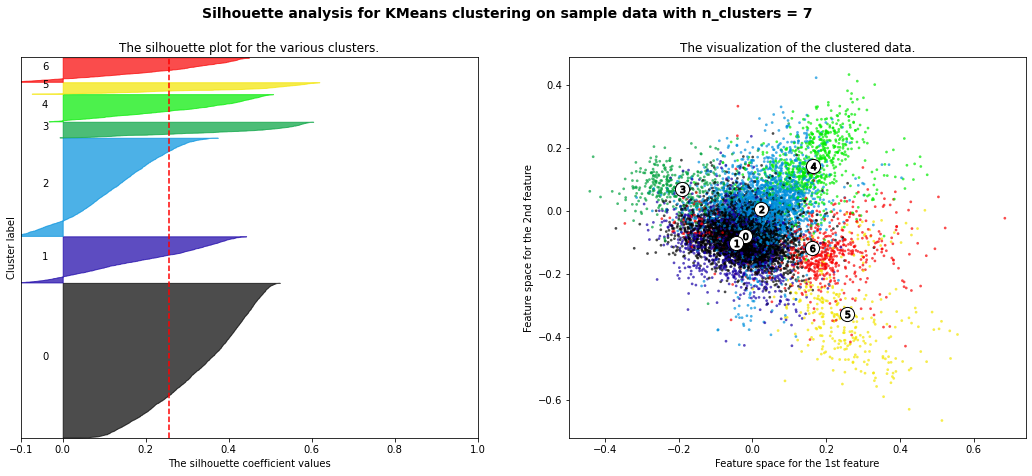

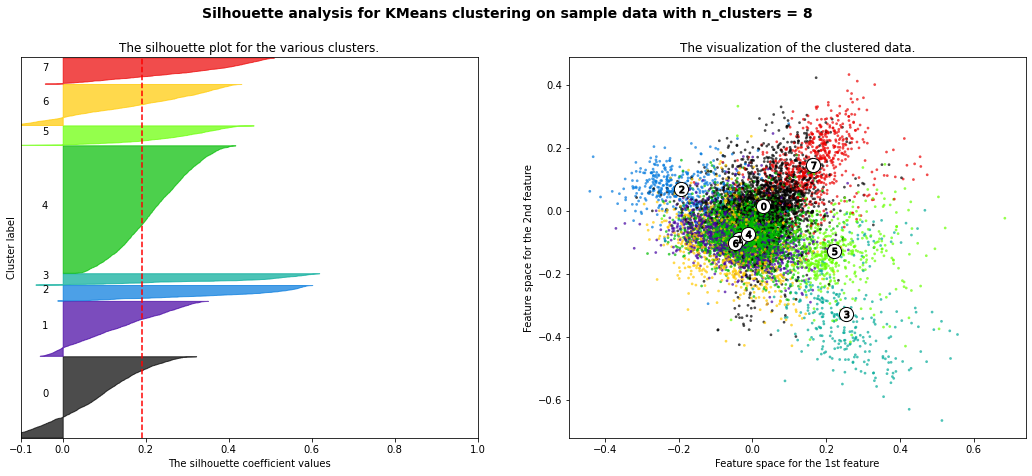

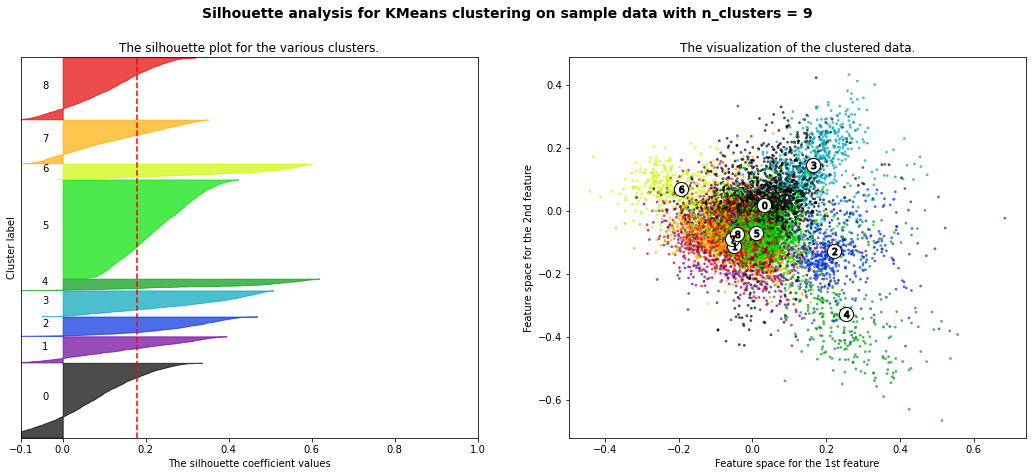

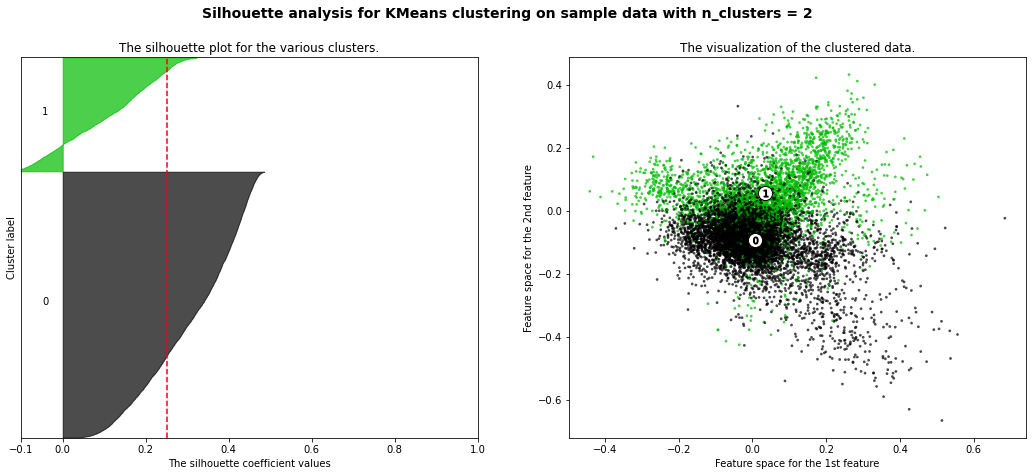

In [296]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np



range_n_clusters = [5, 6,7,8,9,2]
X = np.array(vectorized_docs)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

In [308]:
from sklearn.metrics import davies_bouldin_score


silhouette_avg = []
Sum_of_squared_distances = []
db = []
for num_clusters in range_n_clusters:
    # initialise kmeans
    km = KMeans(n_clusters=num_clusters).fit(vectorized_docs)
    cluster_labels = km.labels_
    
    # silhouette score
    silhouette_avg.append(silhouette_score(vectorized_docs, cluster_labels))
    
    Sum_of_squared_distances.append(km.inertia_)
        
    db.append(davies_bouldin_score(vectorized_docs,cluster_labels))
def plot(heading, x_label, y_label, metric):
    plt.plot(range_n_clusters, metric, 'bx-')
    plt.xlabel(x_label) 
    plt.ylabel(y_label) 
    plt.title(heading)
    plt.show()

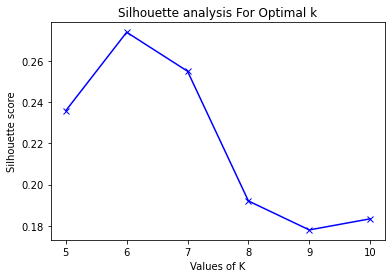

In [309]:
plot('Silhouette analysis For Optimal k', 'Values of K', 'Silhouette score', silhouette_avg)

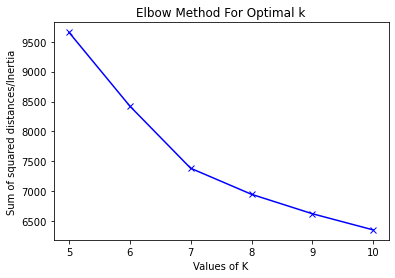

In [310]:
plot('Elbow Method For Optimal k', 'Values of K', 'Sum of squared distances/Inertia', Sum_of_squared_distances)


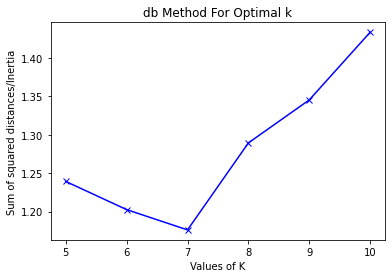

In [311]:
plot('db Method For Optimal k', 'Values of K', 'Sum of squared distances/Inertia', db)

In [298]:
clustering, cluster_labels = mbkmeans_clusters(X=vectorized_docs, k=7, print_silhouette_values=True)
df_clusters = pd.DataFrame({
    "text": docs,
    "tokens": [" ".join(text) for text in tokenized_docs],
    "cluster": cluster_labels
})



C:\Users\dell\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1024 or by setting the environment variable OMP_NUM_THREADS=2
  warnings.warn(


For n_clusters = 7
Silhouette coefficient: 0.28
Inertia:8399.043314002905
Silhouette values:
    Cluster 1: Size:5480 | Avg:0.33 | Min:0.02 | Max: 0.53
    Cluster 4: Size:581 | Avg:0.32 | Min:-0.09 | Max: 0.56
    Cluster 6: Size:250 | Avg:0.29 | Min:-0.07 | Max: 0.50
    Cluster 3: Size:1160 | Avg:0.25 | Min:-0.09 | Max: 0.50
    Cluster 5: Size:788 | Avg:0.18 | Min:-0.17 | Max: 0.42
    Cluster 0: Size:1506 | Avg:0.15 | Min:-0.10 | Max: 0.39
    Cluster 2: Size:117 | Avg:0.08 | Min:-0.16 | Max: 0.28


In [299]:
# print("Top terms per cluster (based on centroids):")
for i in range(7):
    tokens_per_cluster = ""
    most_representative = model.wv.most_similar(positive=[clustering.cluster_centers_[i]], topn=7)
    
    for t in most_representative:
        tokens_per_cluster += f"{t[0]} "
    print(f"Cluster {i}: {tokens_per_cluster}")
print(most_representative)   

Cluster 0: identified indiana courtroom assaulting accident custody happened 
Cluster 1: opens asian produced mail sets orleans television 
Cluster 2: hurricanes grapple forecast strength brewing northwestern bahamians 
Cluster 3: undermine aides insults impeach ukrainian tweet vizcarra 
Cluster 4: speech labour referendum israels welcomed suspension donohoe 
Cluster 5: coffee watching entertainment anticipated guide deals wars 
Cluster 6: charleston carolinas ravaged islands linow ocracoke flooding 
[('charleston', 0.99468994140625), ('carolinas', 0.9916156530380249), ('ravaged', 0.9890457987785339), ('islands', 0.9886330962181091), ('linow', 0.9866597056388855), ('ocracoke', 0.9864428043365479), ('flooding', 0.9862538576126099)]


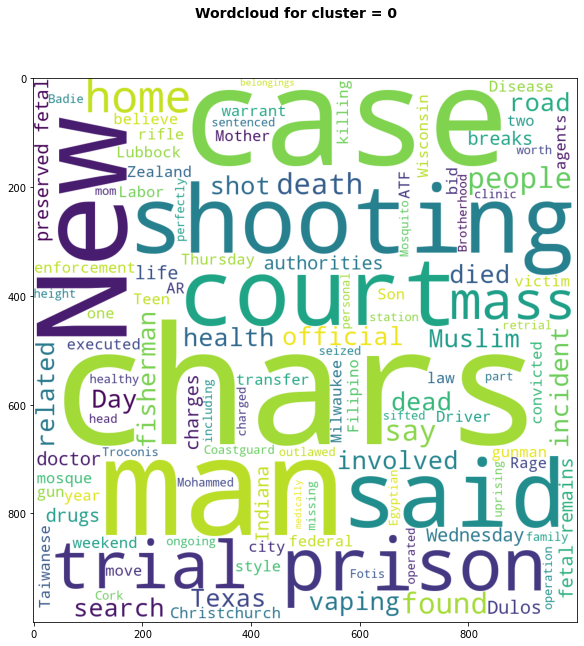

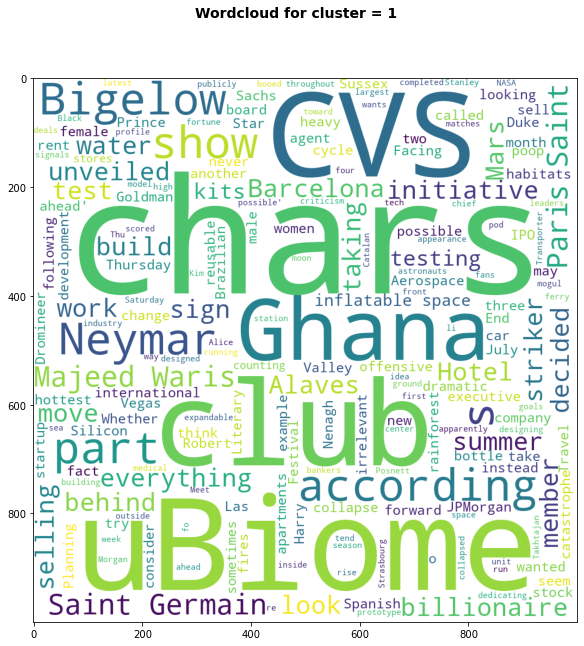

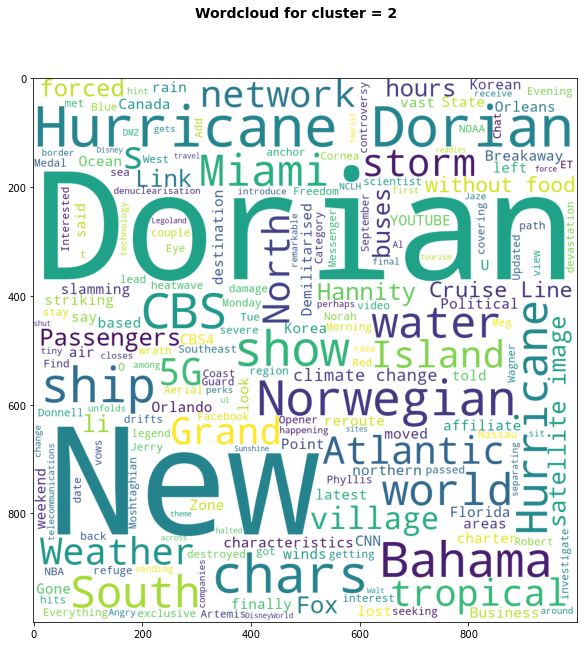

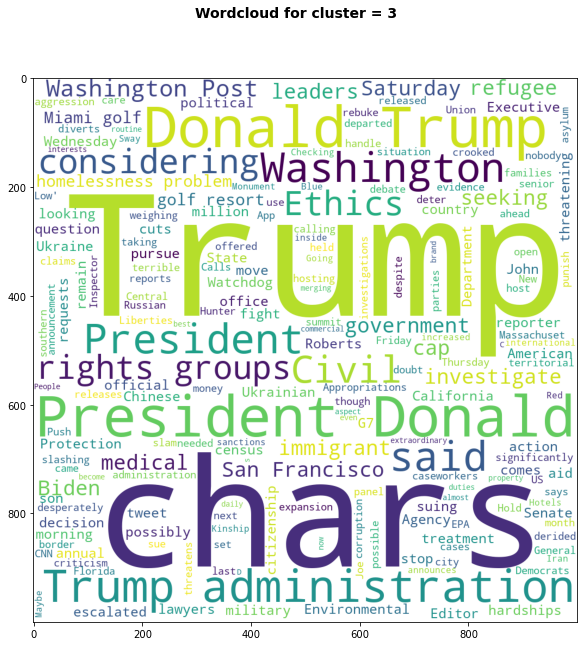

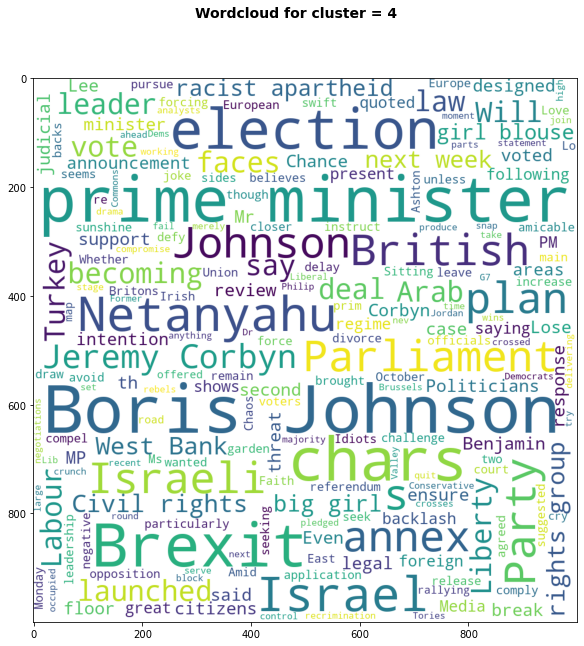

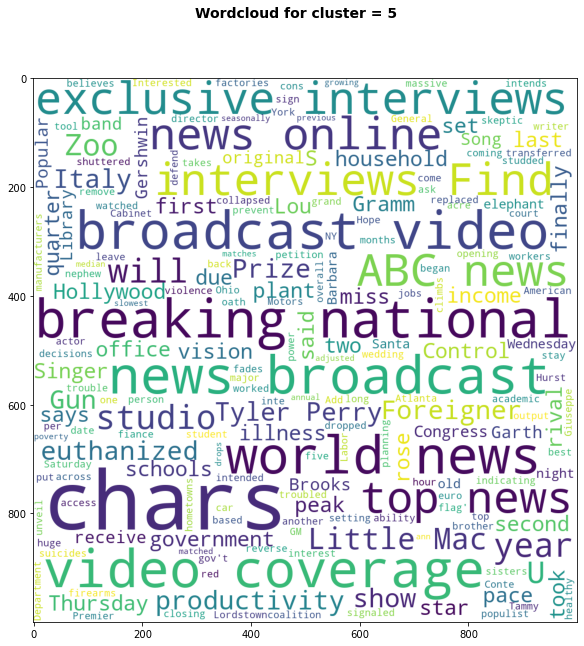

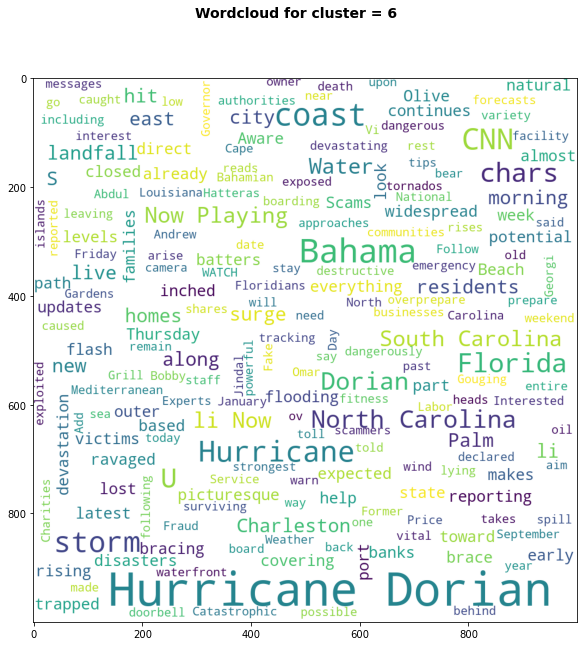

In [300]:
for i  in  range(7) :
    data = []
    test_cluster = i
    most_representative_docs = np.argsort(
        np.linalg.norm(vectorized_docs - clustering.cluster_centers_[test_cluster], axis=1)
    )
    
    for d in most_representative_docs[:10]:
        data.append(docs[d])

    data = ' '.join(data)
   
    wordcloud = WordCloud(width = 1000, height = 1000, 
            background_color ='white', 
            min_font_size = 14).generate(data) 

    plt.figure(figsize = (10, 10), facecolor = None) 
    plt.imshow(wordcloud)
    plt.suptitle(
        "Wordcloud for cluster = %d"
        % i,
        fontsize=14,
        fontweight="bold",
    )
   

In [301]:
def preprocess_text(corpus):
    """Pre-process corpus and generate tokens

    Args:
        corpus: corpus to tokenize.

    Returns:
        Tokenized corpus.
    """
    corpus = str(corpus).lower()  # Lowercase words
    corpus = re.sub(r"\[(.*?)\]", "", corpus)  # Remove [+XYZ chars] in content
    corpus = re.sub(r"\s+", " ", corpus)  # Remove multiple spaces in content
    corpus = re.sub(r"\w+…|…", "", corpus)  # Remove ellipsis (and last word)
    corpus = re.sub(r"(?<=\w)-(?=\w)", " ", corpus)  # Replace dash between words
    corpus = re.sub(
        f"[{re.escape(string.punctuation)}]", "", corpus
    )  # Remove punctuation
    

    tokens = word_tokenize(corpus)  # Get tokens from text
    custom_stopwords = set(stopwords.words("english") + ["news", "new", "top"])
    tokens = [t for t in tokens if not t in custom_stopwords]  # Remove stopwords
    tokens = ["" if t.isdigit() else t for t in tokens]  # Remove digits
    tokens = [t for t in tokens if len(t) > 1]  # Remove short tokens
    preprocessed_texts = ' '.join(tokens)
    return preprocessed_texts

df["text"] =  df["article"].map(lambda x: preprocess_text(x))
df["text"]

8155     12th man arrested statutory rape case alabama ...
350      18th century paris apartment elegantly blends ...
8041     19th century home brooklyn gets 21st century m...
4742     1xtras dj ace needs kidney dj presenter reveal...
1071     2nd person us dies lung disease linked vaping ...
                               ...                        
7162     zinedine zidane long real madrid lose patience...
8319     zuckerberg says breaking tech firms make elect...
10336    zverev tsitsipas roll beijing quarters second ...
154      â€˜genocide cardâ€™ myanmar rohingya verificat...
7392     €500000 taken estate dead man without explanat...
Name: text, Length: 9882, dtype: object

In [302]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

random_state =0
n_topics = 7
vec = TfidfVectorizer()
features = vec.fit_transform(docs)
# features.toarray
# print(vec.vocabulary_.keys())
# print(vec.get_feature_names())
# print( clustering.cluster_centers_)
centers = np.array(clustering.cluster_centers_)
# print(centers)

cls = NMF(n_components=n_topics, random_state=random_state)
cls.fit(features)
# k = 3
# svd = TruncatedSVD(k)
# original_centroids = svd.inverse_transform(clustering.cluster_centers_)



C:\Users\dell\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


NMF(n_components=7, random_state=0)

In [303]:
feature_names = vec.get_feature_names()

n_top_words = 15

for i, topic_vec in enumerate(cls.components_):
    print(i, end=' ')
    
    for fid in topic_vec.argsort()[-1:-n_top_words-1:-1]:
        print(feature_names[fid], end=' ')
    print()

0 the to of and is in for it on new are that you its with 
1 news abc broadcast video interviews breaking exclusive online coverage national top find get world and 
2 trump president donald house impeachment the his he to ukraine bolton on us inquiry that 
3 johnson brexit boris minister prime deal british uk to the no he parliament eu his 
4 hurricane dorian bahamas storm the carolina north coast category winds as tropical florida li island 
5 in was the of police her after man his he who old year at she 
6 saudi oil arabia iran attacks drone on facilities aramco houthi yemen attack the kingdom said 


In [304]:
new_articles = [
    "Hurricane Dorian Path Update: Will Storm Hit Palm Beach, Mar-a-Lago? | Hurricane Dorian finally started moving away from the Bahamas after more than a day of battering the island and is expected to bring life-threatening conditions to parts of the East Coast. | Once identified to be in Hurricane Dorian's path, Mar-a-Lago a",
    "Boris Johnson’s Brexit Plan Hits a Wall in Brussels | In Parliament, the British prime minister’s plan won support from some who had voted against Theresa May’s deal. But it was greeted frostily by European Union di"
]

cls.transform(vec.transform(new_articles)).argsort(axis=1)[:,-1]

array([4, 3], dtype=int64)

In [305]:
test_cluster = 5
most_representative_docs = np.argsort(
    np.linalg.norm(vectorized_docs - clustering.cluster_centers_[test_cluster], axis=1)
)
for d in most_representative_docs[:10]:
    print(docs[d])
    print("-------------")
    

Hope of coming back to shuttered GM plant fades for workers | Get breaking national and world news, broadcast video coverage, and exclusive interviews. Find the top news online at ABC news. | In the months since General Motors signaled the closing of its huge car plant in Lordstown, Ohio, Tammy Hurst put off setting a wedding date and watched her fiance, two sisters, a brother and a nephew leave their hometowns for new jobs.
All five transferred … [+4854 chars]
-------------
Italy's new gov't takes office, but how long will it last? | Get breaking national and world news, broadcast video coverage, and exclusive interviews. Find the top news online at ABC news. | Italy's new government took office Thursday, with one of its first decisions indicating it intends to reverse the euro-skeptic vision of the collapsed, populist coalition it replaced.
Premier Giuseppe Conte and his Cabinet took an oath to defend Italy's inte… [+3023 chars]
-------------
Tyler Perry believes his studio rivals Ho